## Preprocessing

In [1]:
## Packages
##Imports
import pandas as pd
import transformers
import openpyxl
import numpy
import torch

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Ti'

In [5]:
## Reading in the PSYTar data set and parsing it

## Use sentence_labelling sheet

fileName=".\ONLINE_FORA\PsyTAR_dataset.xlsx"
data=pd.ExcelFile(fileName)
sheets={}
for sheet in data.sheet_names:
    sheets[sheet]=data.parse(sheet)

## Remove the first two sheets (License and read_me)
sheets.pop('License',None)
sheets.pop('read_me',None)

## This will print out the sheet names for the whole excel
for sheet in sheets.keys():
    print(f"Sheet Name: {sheet}")

#To access a sheet, perform sheet['Sheet_Name']; e.g., sheets['Sample']

Sheet Name: Sample
Sheet Name: Sentence_Labeling
Sheet Name: ADR_Identified
Sheet Name: ADR_Mapped
Sheet Name: WD_Identified
Sheet Name: WD-Mapped 
Sheet Name: SSI_Identified
Sheet Name: SSI_Mapped
Sheet Name: DI_Identified
Sheet Name: DI_Mapped


## TFIDF K-Means

In [6]:
## Vectorize data into TF-IDF and preprocess data

import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer


def preprocess(text):
    text=str(text)
    tokens=nltk.word_tokenize(text.lower())
    tokens_clean=[t for t in tokens if (t not in stop_words) and (t not in punctuations)]
    return ' '.join(tokens_clean)
    
stop_words=nltk.corpus.stopwords.words('english')
punctuations=string.punctuation

df=data.parse('Sentence_Labeling')
df.drop(df.tail(1).index,inplace=True)
df['drug_id']=df['drug_id'].str.lower()
df['drug_name']=df['drug_id'].str.replace(r'\.\d+','',regex=True)
df['sentences']=df['sentences'].apply(preprocess)
df.fillna(0,inplace=True)
unique_drug_count=df['drug_name'].nunique()

tfidf=TfidfVectorizer()
tfidfSentences=tfidf.fit_transform(df['sentences'])

print(tfidfSentences)

print('Number of Drug Types:',unique_drug_count)
print(df)

## ADR: adverse drug reaction
## WD: withdrawal symptom
## EF: effective
## INF: ineffective
## SSI: Sign/symptom/illness - if report contains explicit SSI that patient experienced that are not a result of the drug
## DI: drug indication - shows SSI that explicitly mentioned as being resolved because of drug consumption

  (0, 2183)	0.3560733570424169
  (0, 2858)	0.5335210557775061
  (0, 2980)	0.33695305203929327
  (0, 4715)	0.3577130194209486
  (0, 4193)	0.36113778160835414
  (0, 2071)	0.2627216248356759
  (0, 5156)	0.2390135798252401
  (0, 1829)	0.30083291559032393
  (1, 2765)	0.4585168729312828
  (1, 1351)	0.8886857021677111
  (2, 2263)	0.2708094866549267
  (2, 4586)	0.4316846093641784
  (2, 5071)	0.44358904667953863
  (2, 4827)	0.2570546169681927
  (2, 3078)	0.23875893121623276
  (2, 4151)	0.3207489298964512
  (2, 1492)	0.29911785906957045
  (2, 1201)	0.35264280744022497
  (2, 4287)	0.3220996041881179
  (3, 4012)	0.534375375933816
  (3, 3326)	0.5729355939201095
  (3, 1018)	0.39488574070665183
  (3, 1237)	0.3054771887014283
  (3, 5)	0.3700495936825698
  (4, 4801)	0.3601630582861626
  :	:
  (6006, 3810)	0.266723700884449
  (6006, 278)	0.30278988091992165
  (6006, 4033)	0.24160419308016043
  (6006, 1558)	0.24160419308016043
  (6006, 2821)	0.21617383387506503
  (6006, 3470)	0.20987895271102364
  (6006,

In [7]:
## Investigate K-means clustering to see whether certain medicines have different side effects - use as baseline to see if there is a significant difference with the transformer model
from sklearn.cluster import KMeans

vocabulary=tfidf.get_feature_names_out()
print(vocabulary)

num_clusters=4
km = KMeans(n_clusters=num_clusters,random_state=42)
km.fit(tfidfSentences)
top_words=km.cluster_centers_.argsort()
print(vocabulary[top_words])
df['cluster']=km.labels_

['00' '04' '06' ... 'zoning' 'zopiclone' 'zyprexa']
[['00' 'paramedics' 'paralyzing' ... 'though' 'feel' 'even']
 ['easliy' 'snowball' 'smptoms' ... 'depression' 'effects' 'side']
 ['00' 'pantry' 'pant' ... 'side' 'effects' 'drug']
 ['kidney' 'nose' 'notable' ... 'day' 'first' 'taking']]


drug_name
cymbalta     1707
effexorxr    1549
lexapro      1492
zoloft       1261
Name: count, dtype: int64
drug_name  cymbalta  effexorxr  lexapro  zoloft
cluster                                        
0                45         45       23      21
1              1326       1192     1178    1012
2                97        122       55      54
3               239        190      236     174


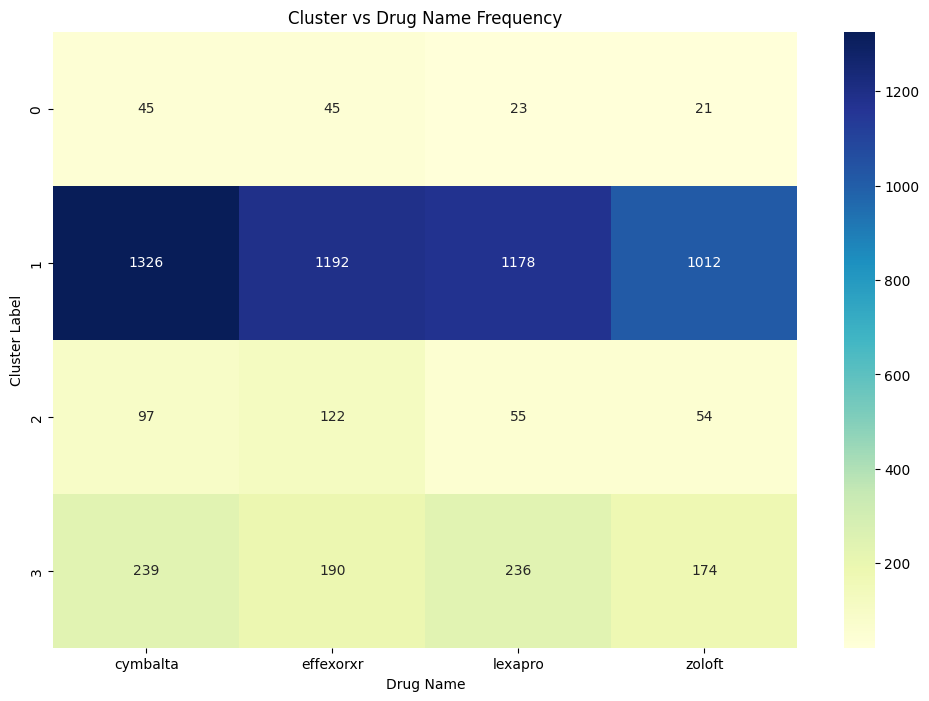

Chi2: 45.95915230961694, p-value: 6.128152407241562e-07


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

print(df['drug_name'].value_counts())

contingency_table = pd.crosstab(df['cluster'], df['drug_name'])
print(contingency_table)

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Cluster vs Drug Name Frequency')
plt.ylabel('Cluster Label')
plt.xlabel('Drug Name')
plt.show()

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2: {chi2}, p-value: {p}")

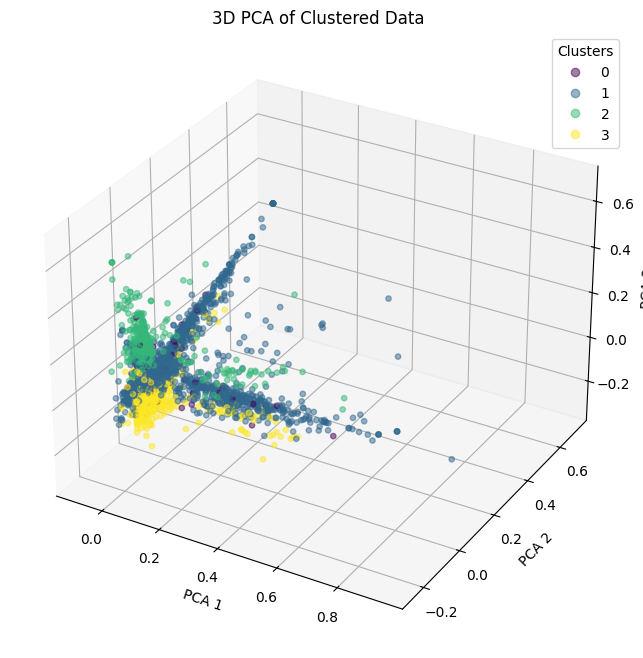

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.cluster import KMeans


pca = PCA(n_components=3) 
X_dim = pca.fit_transform(tfidfSentences.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_dim[:, 0], X_dim[:, 1], X_dim[:, 2], c=km.labels_, cmap='viridis', s=15, alpha=0.5)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.dist=12
legend = ax.legend(*scatter.legend_elements(), loc='upper right', title="Clusters")

plt.title('3D PCA of Clustered Data')
plt.show()

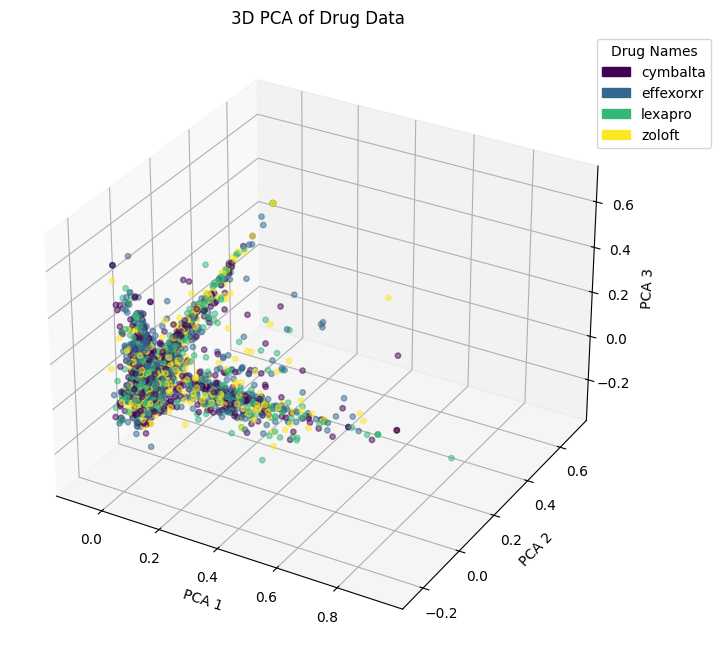

In [10]:
from sklearn.preprocessing import LabelEncoder
from matplotlib.patches import Patch
import numpy as np

label_encoder = LabelEncoder()
drug_labels = label_encoder.fit_transform(df['drug_name'])

pca = PCA(n_components=3) 
X_dim = pca.fit_transform(tfidfSentences.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_dim[:, 0], X_dim[:, 1], X_dim[:, 2], c=drug_labels, cmap='viridis', s=15, alpha=0.5)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

cmap = plt.cm.viridis

legend_handles = [Patch(color=cmap(norm), label=label) for label, norm in zip(label_encoder.classes_, np.linspace(0, 1, len(label_encoder.classes_)))]
ax.legend(handles=legend_handles, title="Drug Names", loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('3D PCA of Drug Data')
plt.show()

## Transformer

In [11]:
## Transformers
from sklearn.model_selection import train_test_split

df['DI'] = pd.to_numeric(df['DI'], errors='coerce')

# Features and labels
x = df['sentences'].values
y = df[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values

# Split data
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.11, random_state=42) 


In [12]:
print('total length=',len(df))
print('%len of training set=',len(x_train)/len(df)*100)
print('%len of validation set=',len(x_val)/len(df)*100)
print('%len of test set=',len(x_test)/len(df)*100)

total length= 6009
%len of training set= 80.09652188384091
%len of validation set= 9.901813945748044
%len of test set= 10.001664170411049


In [13]:
from transformers import AutoTokenizer


max_len=16
train_batch_size=32
dev_batch_size=32
epochs=5
learning_rate=0.5
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(X):
    return tokenizer(X.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')

x_train_tokenized = tokenize_data(x_train)
x_val_tokenized = tokenize_data(x_val)


c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)  # Ensure float dtype
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset instances
train_dataset = TextClassificationDataset(x_train_tokenized, y_train)
val_dataset = TextClassificationDataset(x_val_tokenized, y_val)


In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [16]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6) 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
print(epochs)

5


In [18]:
from torch.optim import AdamW
import torch
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0)}") 

model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop
model.train()
for epoch in range(epochs):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        progress_bar.set_postfix({'loss': loss.item()})

    print(f"Epoch {epoch+1} completed, Last batch loss: {loss.item()}")


Using device: NVIDIA GeForce RTX 3060 Ti


Epoch 1/5:   0%|          | 0/151 [00:00<?, ?it/s]C:\Users\julev\AppData\Local\Temp\ipykernel_28824\1620534317.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1/5:  28%|██▊       | 42/151 [00:11<00:29,  3.74it/s, loss=nan]


KeyboardInterrupt: 